In [1]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from scipy.sparse import coo_matrix
from sklearn.decomposition import NMF, PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

## Load the Data:
* Load the BBC Test Data
* Use the TF-IDF Method to vectorize the text
* Inspect the Data to understand the dataframe Layout
* Visualize the Sample Vectorized Data

We will use Term Frequency - Inverse Document Frequency (TF-IDF). It allows for realtive importance measure of a word in a document compared to multiple other documents. Tne intent is, it will help issolate (give higher importance) to words that are specific to an article and lower weights to those found across multiple articles. Here the sklearns TfidfVectorizer is used to achive the TF-IDF.

In [2]:
X_test = pd.read_csv('data/BBC_News_data/BBC_News_Test.csv')
y_test = pd.read_csv('data/BBC_News_data/BBC_News_Sample_Solution.csv')
X_train = pd.read_csv('data/BBC_News_data/BBC_News_Train.csv')
y_train = X_train.Category
X_test = X_test.Text
X_train = X_train.Text
y_test = y_test.Category
catagories = y_train.unique()
no_categories = len(catagories)

print(X_test.info())
print(y_test.info())

print(X_train.info())
print(y_train.info())


<class 'pandas.core.series.Series'>
RangeIndex: 735 entries, 0 to 734
Series name: Text
Non-Null Count  Dtype 
--------------  ----- 
735 non-null    object
dtypes: object(1)
memory usage: 5.9+ KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 735 entries, 0 to 734
Series name: Category
Non-Null Count  Dtype 
--------------  ----- 
735 non-null    object
dtypes: object(1)
memory usage: 5.9+ KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 1490 entries, 0 to 1489
Series name: Text
Non-Null Count  Dtype 
--------------  ----- 
1490 non-null   object
dtypes: object(1)
memory usage: 11.8+ KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 1490 entries, 0 to 1489
Series name: Category
Non-Null Count  Dtype 
--------------  ----- 
1490 non-null   object
dtypes: object(1)
memory usage: 11.8+ KB
None


## Analyse the Dataframes loaded
* look at number of samples per category
* Look for any obvious patterns 

Category Counts in the Training Data
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64
Category Counts Plot


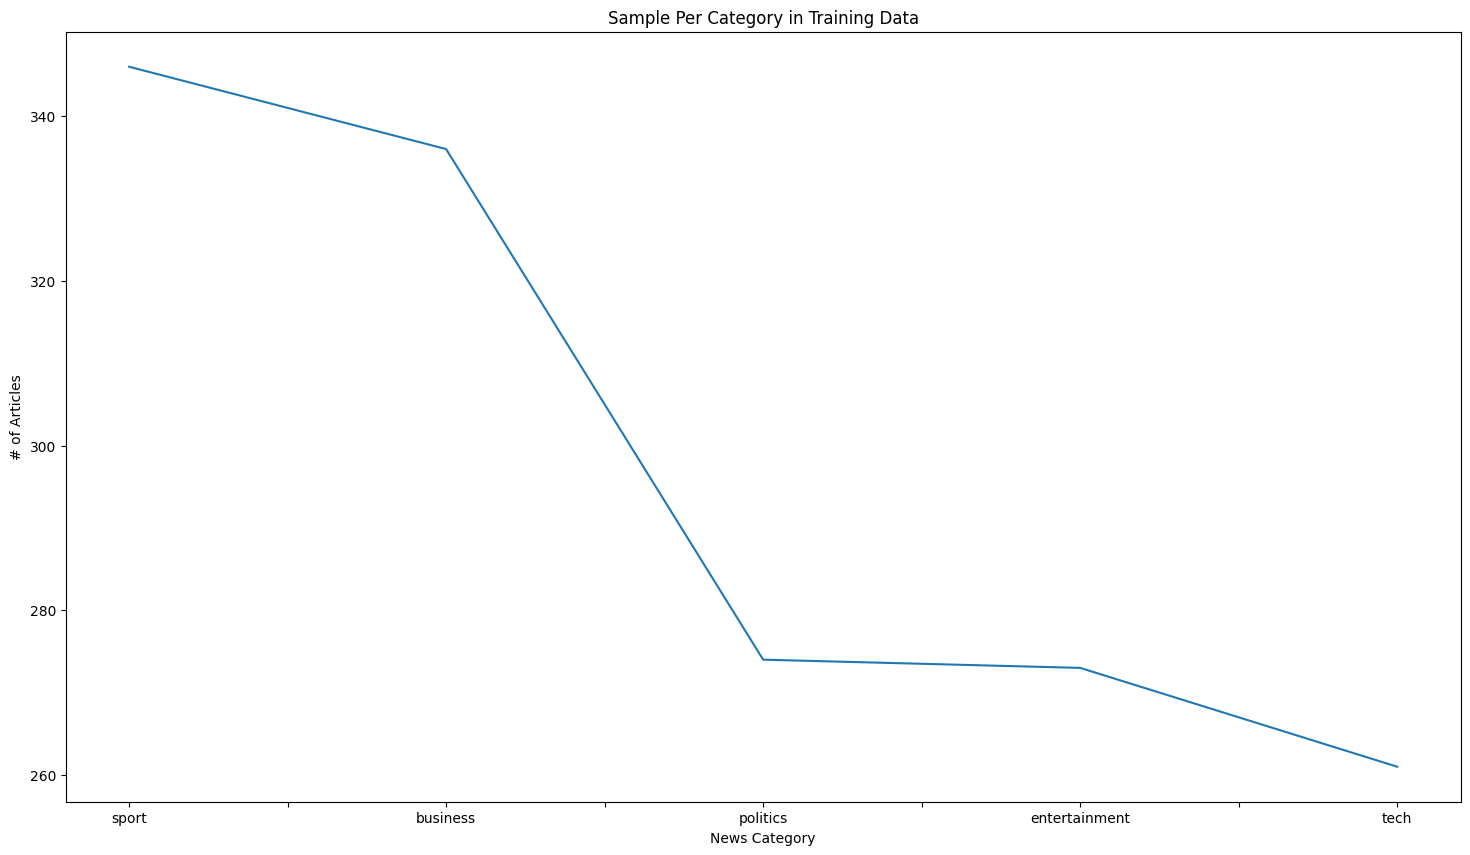

In [3]:
category_counts = y_train.value_counts()
print ("Category Counts in the Training Data")
print (category_counts)

print ("Category Counts Plot")
plt.figure(figsize=(18, 10))
category_counts.plot()
plt.title('Sample Per Category in Training Data')
plt.xlabel('News Category')
plt.ylabel('# of Articles')
plt.show()


## Observations from the Graph
* We can see that there is a reasonably even distribution of samples per category (Difference between Sports to Tech interms of training sample, its only 25% smaller)
* This means we will prevent one category from biasing the training

## Look for Common Words, to figure out what can be ommitied from the training data. 

the     34992
to      16568
of      12970
and     12366
a       12102
in      11696
s        5899
for      5773
is       5478
that     5207
it       5000
on       4991
was      4019
he       3866
be       3803
with     3482
said     3401
has      3250
as       3245
have     3133
at       3032
by       2969
will     2962
but      2902
are      2840
i        2392
from     2382
not      2210
-        2125
they     2059
mr       1969
his      1967
an       1872
we       1857
this     1794
Name: count, dtype: int64


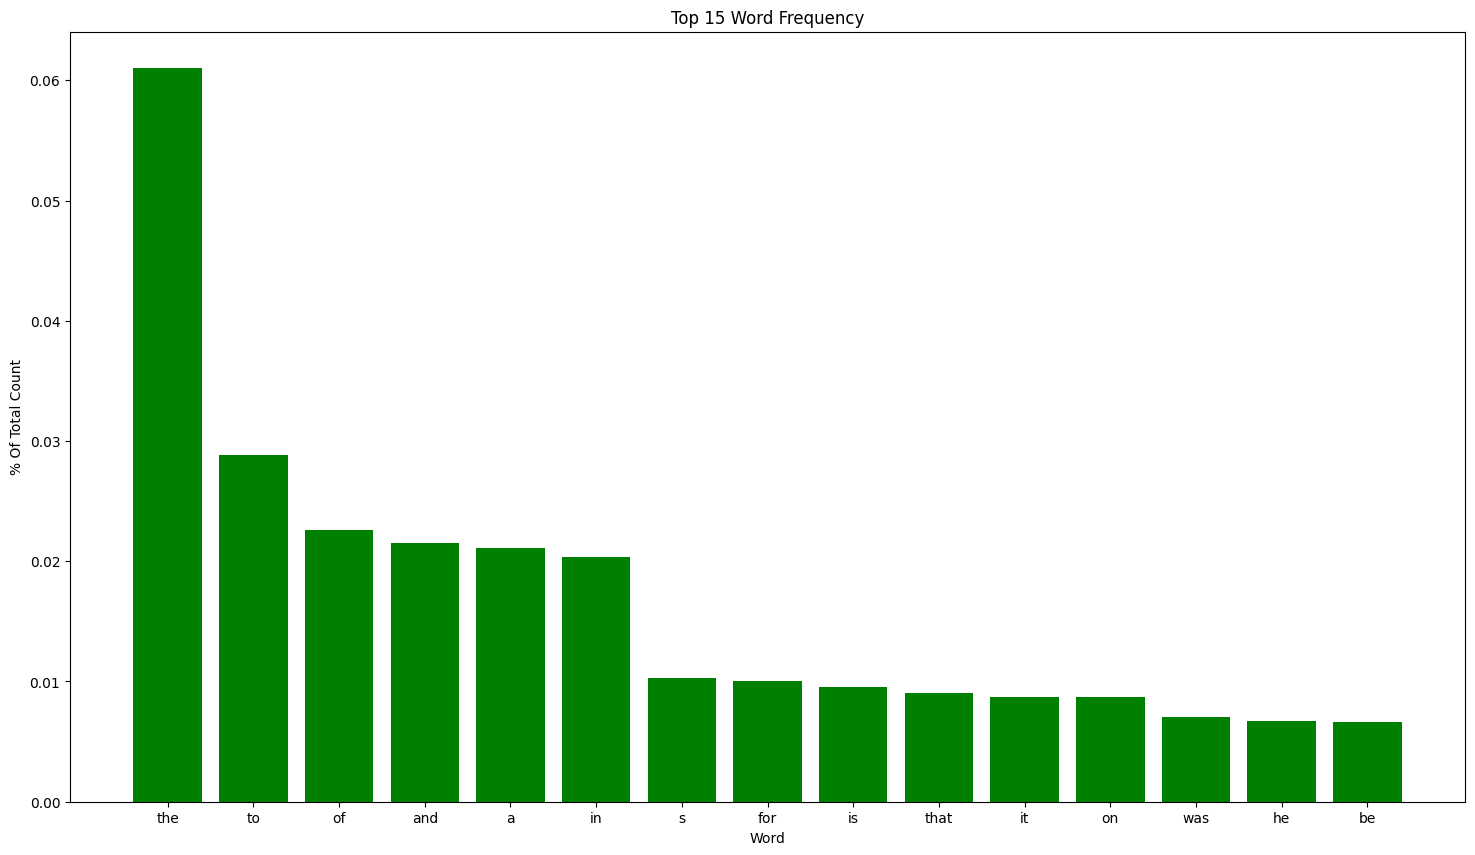

In [4]:
# Based on : https://programminghistorian.org/en/lessons/counting-frequencies
# Look at occurances of words in the dataset

word_frq = X_train.str.split(expand=True).unstack().value_counts()
frq_plot = word_frq[:15] / np.sum(word_frq)
print (word_frq[:35] )
plt.figure(figsize=(18, 10))
plt.bar(frq_plot.index, frq_plot.values, color='Green')
plt.title('Top 15 Word Frequency')
plt.xlabel('Word')
plt.ylabel('% Of Total Count')
plt.show()

## Word Frequecy Based Data Cleaning
* We can see from the word Count, after the fift word the numbe of samples in the data drops to below 0.01% of the sample size
* 5 words that dominate the sample size (the, to, of, and, a, in) Are stopwords and would not add any unique information to the trainning so we can remove them
* We will remove digits, and punctiations as well
* We will use NLTK to remove stop words and use TI/IDF to vectorize the remaining words
* We should also note, the words Said seems to be very common in this data set, which is genrally not a stop word, lets remove that out as well

# Create a Model
For this case, we need to use SVD for categorization, so we will use Sklearn's SVD fundtion to categorizat the test data.



In [5]:
def filter_words(doc):
    text = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    tokens = wordpunct_tokenize(text)
    word_list = ['said', 'BBC', 'news', 'bbc', 'market']
    _filtered_words = [word for word in tokens if word.lower() not in stopwords.words('english') and word.isalpha() and word not in word_list]
    return ' '.join(_filtered_words)

X_train['clean_text'] = X_train.apply(lambda x: filter_words(x))

# Visualize the cleaning
Lets make sure out cleaning had an impact

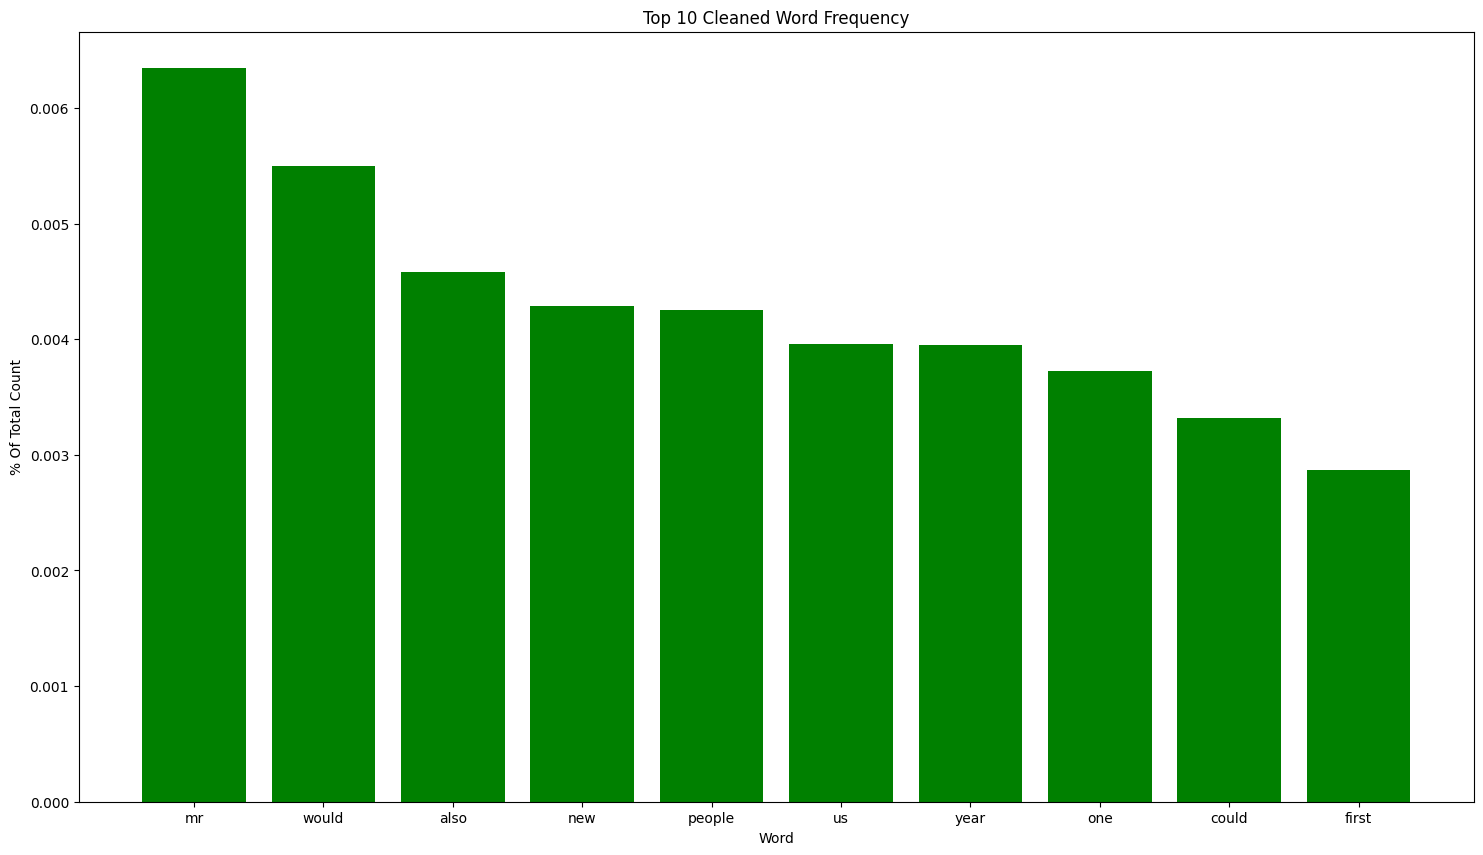

In [6]:
word_frq = X_train.clean_text.str.split(expand=True).unstack().value_counts()
frq_plot = word_frq[:10] / np.sum(word_frq)
plt.figure(figsize=(18, 10))
plt.bar(frq_plot.index, frq_plot.values, color='Green')
plt.title('Top 10 Cleaned Word Frequency')
plt.xlabel('Word')
plt.ylabel('% Of Total Count')
plt.show()

Clean the Test data as well for accuracy testing later

In [7]:
X_test['clean_text'] = X_test.apply(lambda x: filter_words(x))

# TF/IDF
Here we will use TF/IDF to vectorise our word array into numerical vectors to use in our SVD factorization.
* TF is the term frequency count, it looks for the relative frequency of a word within the row of words. Frequncy in thie context is the ratio of term occurs to the total number of terms.
* IDF is the inverse document frequency and tries to meassure the realtive importance of a word in the document. In essense IDF tries to quatify the amount of information a word is providing in that document.  This done by looking at the log of the ratio of the total number of documents in the data set to the number of documents with a word.
* This section is largely based on the instructions from https://www.capitalone.com/tech/machine-learning/scikit-tfidf-implementation/

In [8]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english',lowercase=True, analyzer='word', max_df=0.95, min_df=1, max_features=1000)

tfidf_train = tfidf_vectorizer.fit_transform(X_train.clean_text).toarray()
tfidf_test = tfidf_vectorizer.fit_transform(X_test.clean_text).toarray()
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()


## Questions to Answer for Step 2

1) When you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?

* Since we are trying to find patterns for categories, adding words from the test data to the training would cause overfitting, or reduce the gneralization of the model. Thus it best to leave them out of training to evaluate how generic our model is.

2) Build a model using the matrix factorization method(s) and predict the train and test data labels. Choose any hyperparameter (e.g., number of word features) to begin with.
* In the notebook we explored NMF and SVM useing TD/IDF to vecotrize the words. Features more than 5000 added no value to the model interms of increasing accuracy or imporving performance. 

3) Measure the performances on predictions from both train and test datasets. You can use accuracy, confusion matrix, etc., to inspect the performance. You can get accuracy for the test data by submitting the result to Kaggle. 
* Did not submit to Kaggle, however the awnser for the test data was provided, so it was used for evaluation. With truncatedSVD the best accuracy recieved was 0.32, in general most tuning resutled in an accuract of ~0.2. This is nor supprising as the explaing varaince sum did not exceed 0.03.

4) Change hyperparameter(s) and record the results. We recommend including a summary table and/or graphs.
* I tried tuning NMF parameters with the number of word featrures and gamma values, the max accuracy I achieved was 0.29. The expected was 0.9, so there is work still needed in input cleaning

5) Improve the model performance if you can- some ideas may include but are not limited to; using different feature extraction methods, fit models in different subsets of data, ensemble the model prediction results, etc. 

In [9]:
#build the SVD Model
svd = TruncatedSVD(n_components=no_categories, n_iter = 50, random_state=0)
svd.fit(tfidf_train)
categories_predictions = svd.components_
print(categories_predictions.shape) #confirm its a 5xsample_size matrix
print(categories_predictions)
print (svd.get_feature_names_out())

(5, 1000)
[[ 0.01424346  0.03376058  0.01765833 ...  0.02761923  0.02256999
   0.0154733 ]
 [ 0.00137943 -0.00253664 -0.03222229 ... -0.01699582  0.02882829
  -0.02387545]
 [-0.002192   -0.01117323 -0.01527543 ...  0.01089784 -0.03808705
   0.02549338]
 [-0.00351762 -0.00832248  0.07193952 ...  0.0147654  -0.02596938
  -0.01873926]
 [ 0.01595347  0.03475281 -0.01211709 ...  0.00628152 -0.07288758
  -0.00739901]]
['truncatedsvd0' 'truncatedsvd1' 'truncatedsvd2' 'truncatedsvd3'
 'truncatedsvd4']


## We need to conver the feature names from trunkcatedsvdX to something meaningful.
* I was not able to figure out a automatic way to do this, so i guessed based on the outputs of mapping the category predictions to the tfid feature names
guess is based on looking at the top few sorted words in the tfid mapping.

In [10]:
print("Feature Name Mapping")
i = 1
for category in categories_predictions:
    print ("truncatedsvd:", i)
    print (tfidf_feature_names[(np.argsort(category))[:5]])
    print (tfidf_feature_names[(np.argsort(-category))[:5]])
    i+=1

Feature Name Mapping
truncatedsvd: 1
['ministers' 'view' 'love' 'minister' 'google']
['named' 'nintendo' 'pc' 'year' 'food']
truncatedsvd: 2
['food' 'george' 'big' 'expected' 'went']
['named' 'know' 'board' 'evidence' 'growing']
truncatedsvd: 3
['boerse' 'russia' 'food' 'foreign' 'monday']
['know' 'board' 'expected' 'evidence' 'named']
truncatedsvd: 4
['expected' 'george' 'boerse' 'play' 'cuts']
['food' 'big' 'ban' 'actress' 'ball']
truncatedsvd: 5
['boerse' 'hard' 'europe' 'olympic' 'battle']
['monday' 'pc' 'national' 'team' 'university']


* Based on the mapping Guess is as follows (Business was easy to spot based on words, so was sports, but the other three were guesses)
'truncatedsvd0' = "tech"  
'truncatedsvd1' = "politics"
'truncatedsvd2' = "business"
'truncatedsvd3' = "sport"
'truncatedsvd4' = "entertainment" 

In [11]:
category_lookup_table = ['tech', 'politics', 'business', 'sport', 'entertainment']

[0.00294626 0.02267376 0.01856139 0.01834559 0.01512504]
0.07765203618262767
[8.79686356 5.68925533 5.13176024 5.10018802 4.62907124]


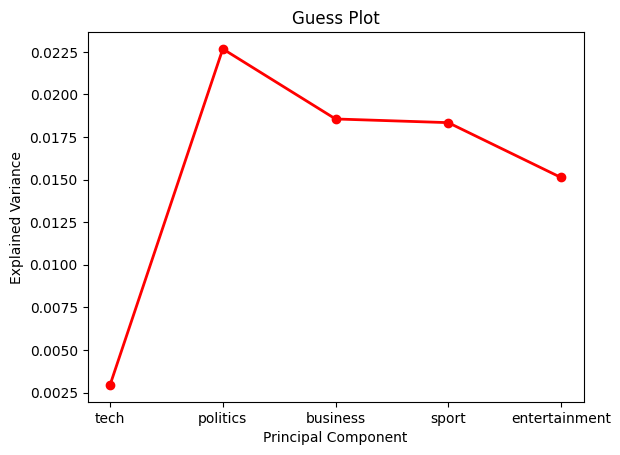

In [12]:
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)

plt.plot(category_lookup_table, svd.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Guess Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

As we can see the 5 categories only exmplain a little of the explained variance.
lets see how this model performs on the test data

In [13]:
y_vector = svd.transform(tfidf_test)
max_index = np.argmax(y_vector,axis=1)
y_pred = [category_lookup_table[max_index[i]] for i in range(len(max_index))]
print(accuracy_score(y_test, y_pred))

0.20272108843537415


In [14]:
def confusion_matrix_plot(m, k=no_categories):
    cm = pd.DataFrame(m, range(k), range(k))
    sns.heatmap(cm, annot=True) # font size
    plt.show()

# Observations
As we can see the results are not that great. All tuning paramenter (number of components for the vecots, df, ds, have litle to no effect o nthe overall accuracy)

In [15]:
nmf = NMF(
    n_components=no_categories, 
    random_state=0, 
    init = "nndsvda", 
    beta_loss="frobenius",
    alpha_W=0.001,
    alpha_H=0.001,
    )

transofrm = nmf.fit_transform(tfidf_train)
category_predictions_nmf = nmf.components_
 
print("Feature Name Mapping for NMF")
i = 1
for category in category_predictions_nmf:
    print ("truncatedsvd:", i)
    print (tfidf_feature_names[(np.argsort(category))[:5]])
    print (tfidf_feature_names[(np.argsort(-category))[:5]])
    i+=1

Feature Name Mapping for NMF
truncatedsvd: 1
['play' 'national' 'music' 'ms' 'mr']
['boerse' 'hard' 'year' 'europe' 'foreign']
truncatedsvd: 2
['standard' 'programme' 'program' 'profit' 'chief']
['george' 'expected' 'went' 'cuts' 'viewers']
truncatedsvd: 3
['robinson' 'mark' 'end' 'education' 'economic']
['named' 'know' 'board' 'evidence' 'budget']
truncatedsvd: 4
['yukos' 'old' 'olympic' 'opening' 'devices']
['food' 'big' 'ban' 'ball' 'actress']
truncatedsvd: 5
['yukos' 'yugansk' 'level' 'let' 'leader']
['pc' 'monday' 'national' 'team' 'period']


In [16]:
category_lookup_table_nmf = ['politics', 'entertainment','tech', 'sports', 'business' ]

In [17]:
y_vector = nmf.transform(tfidf_test)
max_index = np.argmax(y_vector,axis=1)
y_pred = [category_lookup_table_nmf[max_index[i]] for i in range(len(max_index))]
print (y_test)
print (y_pred[:-10])
print(accuracy_score(y_test, y_pred))

0              sport
1               tech
2           business
3      entertainment
4           politics
           ...      
730            sport
731             tech
732         business
733    entertainment
734         politics
Name: Category, Length: 735, dtype: object
['tech', 'business', 'business', 'tech', 'entertainment', 'sports', 'entertainment', 'politics', 'politics', 'business', 'tech', 'business', 'politics', 'business', 'business', 'business', 'entertainment', 'politics', 'tech', 'sports', 'tech', 'entertainment', 'tech', 'business', 'entertainment', 'business', 'entertainment', 'business', 'entertainment', 'business', 'politics', 'business', 'tech', 'politics', 'entertainment', 'business', 'entertainment', 'business', 'politics', 'tech', 'politics', 'sports', 'entertainment', 'entertainment', 'entertainment', 'business', 'business', 'business', 'entertainment', 'politics', 'entertainment', 'sports', 'politics', 'politics', 'business', 'business', 'entertainment', 'polit

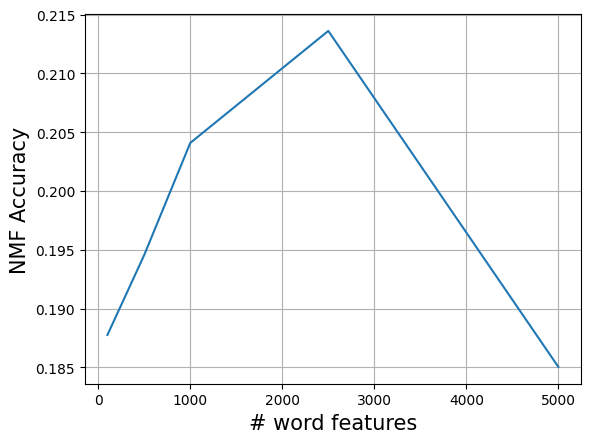

In [18]:
def predictions(model, test_val, tvectorizer, topic_dict):
    tfidf_ = tvectorizer.fit_transform(test_val).toarray()
    tfidf_feature_names = tvectorizer.get_feature_names_out()
    y_vector = model.transform(tfidf_)
    max_index = np.argmax(y_vector,axis=1)
    y_pred = [topic_dict[max_index[i]] for i in range(len(max_index))]
    return y_pred


category_lookup_table_dicts = {5000: ['sport', 'politics', 'business', 'entertainment', 'tech'],
               2500: ['business','politics', 'sport', 'entertainment', 'tech'],
               1000: ['politics', 'sport','business', 'entertainment', 'tech'],
               500: ['business', 'sport', 'entertainment', 'politics', 'tech'],
               100: ['sport','politics','business', 'entertainment', 'tech']}
 
n_feats_lookup = [5000, 2500, 1000, 500, 100]
accuracy_list = []
 
for n_feats in n_feats_lookup:
    tvectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=n_feats) #, tokenizer=LemmaTokenizer())
    vectors = tvectorizer.fit_transform(X_train.clean_text).toarray()
    vocab = np.array(tvectorizer.get_feature_names_out())
    #print(len(vocab))
    nmf = NMF(
            n_components=no_categories, 
            random_state=0, 
            init = "nndsvda", 
            beta_loss="frobenius",
            alpha_W=0.001,
            alpha_H=0.001
        )
 
    nmf.fit(vectors)
    topic_dict = category_lookup_table_dicts[n_feats]
    y_pred = predictions(nmf, X_test.clean_text,  tvectorizer, topic_dict)
    accuracy_list.append(accuracy_score(y_test, y_pred))

plt.plot(n_feats_lookup, accuracy_list)
plt.grid()
plt.xlabel('# word features', size=15)
plt.ylabel('NMF Accuracy', size=15)
plt.show()

## Supervised Learning For Comparrison
We will use 

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

clf =SVC().fit(tfidf_train, y_train)

y_predictions = clf.predict(tfidf_test)
print (accuracy_score(y_test, y_predictions))

0.20680272108843537


The accuracy did not improve further with the predictions, so lets try to automate parameter tuning to see if it helps.

In [20]:

#Code from Introduction to Supervised Learning Week 6 Lab.
def tune_model(clf, param_grid, X_train, y_train, X_val, y_val):    
    grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3, n_jobs=None) 
    grid.fit(X_train, y_train) 
    print('Best params:', grid.best_params_) 
    grid_pred = grid.predict(X_val) 
    print('val score:', grid.score(X_val, y_val))    
    print(classification_report(y_val, grid_pred))  

tune_model(SVC(), 
                     {'C': [0.1, 1, 10, 100],  
                      'gamma':['scale', 'auto'],
                      'kernel': ['linear', 'rbf']}, 
                      tfidf_train, y_train, tfidf_test, y_test)  

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.943 total time=   0.1s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.936 total time=   0.1s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.943 total time=   0.1s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.966 total time=   0.1s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.953 total time=   0.1s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.681 total time=   0.3s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.671 total time=   0.3s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.674 total time=   0.3s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.688 total time=   0.3s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.681 total time=   0.3s
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.943 total time=   0.1s
[CV 2/5] END ..C=0.1, gamma=auto, kernel=linear;

#References:
* Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.
* https://www.geeksforgeeks.org/removing-stop-words-nltk-python/ (How to Use NLPD library to remove Stop Words)
* https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/ (How to use tf-idf to vectorize)
* (Code for Word Freq Counting) https://programminghistorian.org/en/lessons/counting-frequencies

# Movie Matrix with SVD
 

In [21]:
movie_rating = pd.read_csv('data/movie_rating_data/movies.csv')
test_data = pd.read_csv('data/movie_rating_data/test.csv')
train_data = pd.read_csv('data/movie_rating_data/train.csv')
user_rating = pd.read_csv('data/movie_rating_data/users.csv')

In [22]:
def rmse(yp, yt):
    yp[np.isnan(yp)]=3 #In case there is nan values in prediction, it will impute to 3.
    return np.sqrt(((yt-yp)**2).mean())    
    
def predict_to_3(mat):
    mat.fillna(3, inplace=True)
    return mat

In [23]:

#create the rating matrix using week3 code
rating_df = train_data.pivot(index='uID', columns='mID', values='rating')
_imputed_3 = predict_to_3(rating_df)

model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(_imputed_3)
H = model.components_ 

pred_df = pd.DataFrame(data = W @ H,  
                      index = rating_df.index.values, 
                      columns = rating_df.columns.values) 
pred_df['uID'] = pred_df.index.values

pred_df = pd.melt(pred_df, id_vars=['uID'], var_name='mID', value_name='pred_rating')
out_df = pred_df.merge(test_data, on=['uID', 'mID'])

print (out_df.info())
#print (test_data.rating)
print ("RMSE:", rmse(out_df.pred_rating, out_df.rating))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300006 entries, 0 to 300005
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   uID          300006 non-null  int64  
 1   mID          300006 non-null  object 
 2   pred_rating  300006 non-null  float64
 3   rating       300006 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 9.2+ MB
None
RMSE: 1.0939986984862577


As we can see above, the RMSE (1.09) is better than the Baseline from week 3 of 1.25, however it is not as good as the Cooporative method. There should be an improvement based on week 3 to switch from a default fill of 3 in empty spaces to teh average user or movie rating. This was not explored further in this notebook 